In [81]:
#Import the relevant Python modules
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from itertools import combinations as combs
from tqdm import trange
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

# Years

In [2]:
start_date = 1990
end_date = 2017

# Target Data Reading 

## Salmon viability

In [3]:
#Import the relevant data
Salmon_file = pd.read_excel("Data/ZooPlanktonPerryData.xlsx", 5)

#Take years less than or equal to 2017  (year 2018 has only NaN)

Salmon = Salmon_file[Salmon_file["Ocean Entry Year"]<=2017]
Salmon = Salmon.rename(columns={"Ocean Entry Year":"Year"})

In [4]:
# List of salmon types 
year_column = 'Year'
salmonTypes_List =  [col for col in Salmon.columns if col != year_column]

print("Salmon types are:", salmonTypes_List)

Salmon types are: ['Cowichan Chinook', 'Harrison Chinook', 'Puntledge Chinook', 'Big Qualicum Coho']


# Data Reading

## Abiotic Factors

### SST

In [5]:
oldSSTs = pd.read_csv("Data/SSTs")
#For each year I want a list with the SSTs for the months in ascending order. 
SSTsList = []
for year in oldSSTs["Year"].unique():
    SSTsList.append([year] + oldSSTs[oldSSTs["Year"] == year]["SST"].tolist())

SSTs = pd.DataFrame(SSTsList, columns=["Year", "SST Jan.", "SST Feb.", "SST Mar.", "SST Apr.", "SST May", "SST Jun.", "SST Jul.", "SST Aug", "SST Sep.", "SST Oct.", "SST Nov.", "SST Dec."])
SSTs = SSTs[:28]

### Sea Level

In [6]:
## Read the Annual Mean Sea Levels
        #there are data of four ports
#Take the years between start_date and end_date
#Take the positive values (non existent data entered as -99999
#drop the columns 2 and 3 to keep year and sea level measurement
#rename the column that contains Sea Level measurement


file_path="Data/SeaLevel_Point_Atkinson193.txt"
df=pd.read_csv(file_path, header=None,delimiter=';')
df= df[(df[0] >= start_date) & (df[0] <= end_date) & (df[1]>=0)].drop(columns=[2,3])
seaLevelPointA_clean =df.rename(columns={0: 'Year', 1: 'Sea Level Point Atkinson'})
#missing year 1997

file_path="Data/SeaLevel_Port_Angeles2127.txt"
df =pd.read_csv(file_path, header=None,delimiter=';')
df= df[(df[0] >= start_date) & (df[0] <= end_date) & (df[1]>=0)].drop(columns=[2,3])
seaLevelPortA_clean= df.rename(columns={0: 'Year', 1: 'Sea Level Port Angeles'})
#no missing year

file_path="Data/SeaLevel_Campbell_River1323.txt"
df=pd.read_csv(file_path, header=None,delimiter=';')
df= df[(df[0] >= start_date) & (df[0] <= end_date) & (df[1]>=0)].drop(columns=[2,3])
seaLevelCampbellR_clean= df.rename(columns={0: 'Year', 1: 'Sea Level Campbell River'})
#missing year 1995 & 1996

file_path="Data/SeaLevel_Cherry_annualMean.txt"
df= pd.read_csv(file_path, header=None,delimiter=';')
df= df[(df[0] >= start_date) & (df[0] <= end_date) & (df[1]>=0)].drop(columns=[2,3])
seaLevelCherryP_clean= df.rename(columns={0: 'Year', 1: 'Sea Level Cherry'})
#missing year 1994


#Merge the sea Levels
#Calculate their average 
    #missing data is ignored 
        #note: if a year is missing it's only missing at most one of the ports

merged_df= pd.merge(seaLevelPortA_clean, seaLevelPointA_clean, on='Year', how='outer')
merged_df = pd.merge(merged_df, seaLevelCampbellR_clean, on='Year', how='outer')
seaLevels = pd.merge(merged_df, seaLevelCherryP_clean, on='Year', how='outer')

#Average sea levels of four ports
seaLevels['av_SeaLevels']= seaLevels.iloc[:,1:].mean(axis=1, skipna=True)
#has few NaN values, fill them with the average
seaLevels.iloc[7,2] = seaLevels.iloc[7,5]
seaLevels.iloc[5,3] = seaLevels.iloc[5,5] 
seaLevels.iloc[6,3] = seaLevels.iloc[6,5] 
seaLevels.iloc[4,4] = seaLevels.iloc[4,5] 

### Salinity

In [7]:
Salinity_file = pd.read_excel('Data/Entrance_island_salinity.xlsx') 

#Sea salinity is provided monthly, we will calculate yearly average. Also, nonexistent data is marked by 999.99

df_salinity = Salinity_file.replace(999.99,np.nan)
df_salinity_yr = df_salinity['YEAR']
df_salinity_val = df_salinity.drop(['YEAR'],axis=1).mean(axis = 1)
df_sea_salinity = pd.DataFrame({'Year':df_salinity_yr,'Avg Sea Salinity':df_salinity_val})
df_sea_salinity = df_sea_salinity.loc[(df_sea_salinity['Year'] >= start_date) & (df_sea_salinity['Year'] <= end_date)]
df_sea_salinity.reset_index(drop = True, inplace = True)

### NPGO climate index  

In [8]:
# import a climatological index
NPGO_monthly = pd.read_csv('Data/NPGOMonthlyAvg copy.txt')

# get the yearly NPGO averages and clean it up
NPGO_yearly = NPGO_monthly.groupby('Year').mean()
NPGO_yearly = NPGO_yearly.drop(columns=['Month']).reset_index()
NPGO_yearly = NPGO_yearly.loc[(NPGO_yearly['Year']>=start_date) & (NPGO_yearly['Year']<= end_date)]
NPGO_yearly['Year'] = NPGO_yearly['Year'].astype(int)
NPGO=  NPGO_yearly.reset_index().drop(columns=['index'])

### PDO

In [9]:
#read Pacific decadal oscillation(PDO) data
Pdo_file = pd.read_excel('Data/pdo.xlsx','pdo')  


df_pdo = Pdo_file.loc[(Pdo_file['year'] >= start_date) & (Pdo_file['year'] <= end_date)]
df_pdo_clean = df_pdo.rename(columns={'year':'Year'})
df_pdo_avg = df_pdo_clean.groupby(['Year']).mean()
df_pdo_avg = df_pdo_avg.drop(columns = ['date','month'])



### Flow Rate

In [10]:
#read Fraser river flow data
Flow_rate_file = pd.read_excel('Data/Fraser_flow_rate.xlsx','Flow rate')  

df_flow_rate = Flow_rate_file[(Flow_rate_file['Year'] >= start_date) & (Flow_rate_file['Year'] <= end_date) &(Flow_rate_file['PARAM'] == 1)]
df_flow_rate = df_flow_rate.drop(columns = [' ID','PARAM','MM--DD','SYM','MM--DD.1','SYM.1'])
df_flow_rate['Avg flow rate'] = 0.5*(df_flow_rate['MAX']+df_flow_rate['MIN'])
df_flow_rate.rename(columns = {'MAX':'Max flow rate','MIN':'Min flow rate'},inplace = True)
df_flow_rate.reset_index(drop = True, inplace = True)

In [11]:
#Merge Environmental Factors
    #Salinity, PDO, Fraser River Flow Rate, NPGO, sea levels, SSTs
env_factors = pd.merge(df_sea_salinity,df_pdo_avg,on = 'Year',how = 'outer')
env_factors = pd.merge(env_factors, df_flow_rate, on = 'Year', how = 'outer')
env_factors = pd.merge(env_factors, NPGO, on = 'Year', how = 'outer')
env_factors = pd.merge(env_factors, seaLevels, on = 'Year', how = 'outer')
env_factors = pd.merge(env_factors, SSTs, on = 'Year', how = 'outer')

## Biotic Factors

### Predator Populations 


In [12]:
#(4) read Killer Whale data
Whale_file = pd.read_excel('Data/killerwhales_1970to2020.xlsx','killerwhales_1970to2020') 

#(5) read harbour seal population data
Seal_file = pd.read_excel('Data/harbourseals_1970to2020.xlsx','harbourseals_1970to2020')  


df_whale = Whale_file.loc[(Whale_file['Year'] >= start_date) & (Whale_file['Year'] <= end_date)].drop(columns = ['SRKW','srkwSource','nrkwSource'])
df_seal = Seal_file.loc[(Seal_file['year'] >= start_date) & (Seal_file['year'] <= end_date)].drop(columns = ['nonSogNt','bcNt']).rename(columns={'year':'Year'})


df_whale.reset_index(drop = True, inplace = True)
df_seal.reset_index(drop = True, inplace = True)

#Merge df_whale and df_seal
df_pred_factors = pd.merge(df_seal,df_whale, on = 'Year',how = 'outer')
df_pred_factors.rename(columns = {'sogNt':'Harbour seal','NRKW':'Killer whale'},inplace = True)


### Zooplankton

In [13]:
#Read ZooPlanktonPerryData file

xl_file = pd.ExcelFile('Data/ZooPlanktonPerryData.xlsx')

Original_Salmon_Sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

# Biomass Definitions #No Data here. In case info on column names is needed
selected_sheet = "2. Biomass data definitions"  
BiomassDefs = Original_Salmon_Sheets[selected_sheet]


#Extract the zoo plankton anomalies from the excel sheet
anom = Original_Salmon_Sheets['3. Zooplankton anomalies']
anom = anom[6:28] #Drops years before <=1995 (All Nan values) and years after >=2018
zoos = anom.drop(columns=anom.columns[1:3]).reset_index(drop=True)

In [14]:
#obtain  zooplank biomasses
##take the years less than end_date 
##we drop columns that do not give biomass of zooplanktons
selected_sheet = "1. Zooplankton Biomass data"  
df = Original_Salmon_Sheets[selected_sheet]
df= df[df["yr"]<=end_date]
plankBiomass_data=df.drop(columns=['key', 'survey', 'region', 'event', 'net', 'station', 'lon', 'lat', 'mon', 'day', 'time',  'twilight', 'net.type', 'diam.m', 'mesh.um', 'startz.m', 'endz.m','botz.m',
       'volfilt.m3'])

# Create a new DataFrame for averaged values
#Group by 'yr' and calculate the annual mean of Zooplanktons
#drop duplicates
#rename the columns for convenienve
#reset_index

plankBiomassMean = pd.DataFrame()
for column in plankBiomass_data.columns:
    if column in ['yr', 'region']:
        plankBiomassMean[column] = plankBiomass_data[column]
    else:
        name = 'Av_' + column
        plankBiomassMean[name] = plankBiomass_data.groupby('yr')[column].transform('mean')

plankBiomassMean.drop_duplicates(subset=['yr'], inplace=True)
plankBiomassMean.rename(columns={'yr': 'Year', 'Av_Total.Biomass': 'Av_totalBiomass'},  inplace=True)
plankBiomassMean.reset_index(drop=True, inplace=True)




In [15]:
plankton_anm_mass = pd.merge(zoos, plankBiomassMean, on = 'Year',how = 'outer')

In [16]:
biotic_factors = pd.merge(df_pred_factors, plankton_anm_mass, on = 'Year', how = 'outer')


## Anthropogenic Factors

### Catches

In [17]:
#Import the relevant data
Catches = pd.read_excel("Data/Copy of recreational reported fishery catch, 1953-2012.xlsx")

#Next is Catches
ModernCatches = Catches[Catches["YEAR"] >= start_date]
CohoCatches = ModernCatches[ModernCatches["SPECIES_DESC"] == "COHO SALMON"]
ChinookCatches = ModernCatches[ModernCatches["SPECIES_DESC"] == "CHINOOK SALMON"]
cohoAnnualCatchList = []
chinookAnnualCatchList = []
yearList = []
for year in CohoCatches["YEAR"].unique():
    cohoAnnualCatchList.append(CohoCatches[CohoCatches["YEAR"] == year]["PIECES"].sum())
    chinookAnnualCatchList.append(ChinookCatches[ChinookCatches["YEAR"] == year]["PIECES"].sum())
    yearList.append(year)
Catches = pd.DataFrame({"Coho Catch": cohoAnnualCatchList, "Chinook Catch": chinookAnnualCatchList, "Year": yearList})



### BC and WA regional populations and population trends

In [18]:
# import the population data for BC Regional Districts
BC_pop = pd.read_csv('Data/BCPop1990.csv')#, index_col=0) # only need index_col=0 to make years the indices
BC_pop = BC_pop.rename(columns={'Unnamed: 0':'Year'}).drop_duplicates() # there's a duplicate row at 2011!

# pre-2001 BC population numbers are only for every five years
# make an empty table for these years, to be interpolated
missing_yrs = np.setdiff1d([i for i in range(1990,2001)],[1991,1996])
missing_yrs_vals = np.empty((29,9,))*np.nan
missing_data = np.vstack((missing_yrs,missing_yrs_vals)).transpose()
BC_missing = pd.DataFrame(missing_data)
BC_missing.columns = BC_pop.columns
BC_pop = pd.concat([BC_missing,BC_pop]).sort_values(by='Year')

# fill in the missing years with some linearly interpolated values where possible
# and where this doesn't fill in a value, just repeat the closest value
BC_pop = BC_pop.interpolate().bfill() 
# fix the indices obtained from concatenating
BC_pop = BC_pop.reset_index().drop(columns=['index'])


# import the population data for BC Regional Districts and WA Counties
WA_pop = pd.read_csv('Data/WAPop1990.csv')# index_col=0)
WA_pop = WA_pop.rename(columns={'Unnamed: 0':'Year'})

In [19]:
# BC Group 1 average
BC_1 = BC_pop.iloc[:,[3,7,9,10,12,14,18,20,25,28,29]]
BC_1_avg = pd.DataFrame(BC_1.mean(axis=1), columns=['BC Gp1 Avg'])
# BC Group 2 average
BC_2 = BC_pop.iloc[:,[2,5,15,17,19]]
BC_2_avg = pd.DataFrame(BC_2.mean(axis=1), columns=['BC Gp2 Avg'])
# BC Group 3 average
BC_3 = BC_pop.iloc[:,[6,8,11,13,16,22]]
BC_3_avg = pd.DataFrame(BC_3.mean(axis=1),columns=['BC Gp3 Avg'])
# BC Group 4 average
BC_4 = BC_pop.iloc[:,[1,4,24,27]]
BC_4_avg = pd.DataFrame(BC_4.mean(axis=1),columns=['BC Gp4 Avg'])
# BC Group 5 average
BC_5 = BC_pop.iloc[:,[21,23,26]]
BC_5_avg = pd.DataFrame(BC_5.mean(axis=1),columns=['BC Gp5 Avg'])

# WA Group 1 average
WA_1 = WA_pop.iloc[:,[1,3,5,6,8,9,13,16,19,20,21,23,27,29,31,32,34,36,37,39]]
WA_1_avg = pd.DataFrame(WA_1.mean(axis=1),columns=['WA Gp1 Avg'])
# WA Group 2 average
WA_2 = WA_pop.iloc[:,[2,4,18,22,24,25,26,28,30,33,35]]
WA_2_avg = pd.DataFrame(WA_2.mean(axis=1),columns=['WA Gp2 Avg'])
# WA Group 3 average
WA_3 = WA_pop.iloc[:,[11,14,15,17,38]]
WA_3_avg = pd.DataFrame(WA_3.mean(axis=1),columns=['WA Gp3 Avg'])
# WA Group 4 average
WA_4 = WA_pop.iloc[:,[7,10,12]]
WA_4_avg = pd.DataFrame(WA_4.mean(axis=1),columns=['WA Gp4 Avg'])

##### The grouped population variables

It is better to group the regional populations into larger trend groups; these will be the actual population variables to use.


In [20]:
BC_df = pd.concat([  BC_1_avg,
                             BC_2_avg,
                             BC_3_avg,
                             BC_4_avg,
                             BC_5_avg ]
                  , axis=1)
                   
WA_df = pd.concat([ WA_1_avg,
                             WA_2_avg,
                             WA_3_avg ,
                             WA_4_avg ]
                  , axis=1)

populations = pd.concat([WA_pop['Year'] , BC_df, WA_df ]  , axis=1) 
populations  = populations[:28]

### Port of Vancouver tonnage cargo

In [21]:
# data on total tonnage of cargo through Port of Vancouver
# years 2008-2023 are given in the Port Metro Vancouver Statistics Overviews at https://www.portvancouver.com/about-us/statistics/
# years 1994-1998 are given in The Institutional Position of Seaports An International Comparison by Henrik Stevens, Chapter 7
PortofVan = pd.DataFrame({'Year':[1994,1995,1996,1997,1998]+[i for i in range(2008,2023)],  
                          'Tonnage':[67600000,71500000,72000000,73500000,71900000]+[114561990,101887824,118378885, 
                                122499631,123876885,135009878, 
                                139638157,138082585,135538055, 
                                142067550,147090934,144225630, 
                                145450722,146473626,141416326]})

missing_yrs_port = pd.DataFrame({'Year':[1990,1991,1992,1993,1999,2000,2001,2002,2003,2004,2005,2006,2007],
                               'Tonnage':[np.nan for _ in range(0,13)]})

# linearly interpolate the port traffic data
Port_of_Van = pd.concat([PortofVan,missing_yrs_port]).sort_values(by=['Year']).interpolate(method='linear', fill_value='extrapolate', limit_direction='both')
Port_of_Van = Port_of_Van.reset_index(drop=True)
Port_of_Van = Port_of_Van[:28]

In [22]:
human_effects = pd.merge(Catches, populations,on = 'Year', how = 'outer')
human_effects = pd.merge(human_effects, Port_of_Van, on = 'Year', how = 'outer')

# Combine all

In [23]:
#Combine the relevant data into a single data frame
df_merge = pd.merge(env_factors, biotic_factors, on="Year", how="outer")
all_factors = pd.merge(df_merge, human_effects, on="Year", how="outer")


all_data = pd.merge(Salmon, all_factors, on="Year", how="outer")


In [27]:
#Without year column
salmons_features = all_data.drop(columns=['Year'])

In [25]:
salmonTypes_List

['Cowichan Chinook',
 'Harrison Chinook',
 'Puntledge Chinook',
 'Big Qualicum Coho']

In [24]:
#Only one salmon Type
type_number=0
alldata_CC = all_data.drop(columns= [salmonTypes_List[i] for i in range(4) if i != type_number] ) 

type_number=1
alldata_HC = all_data.drop(columns= [salmonTypes_List[i] for i in range(4) if i != type_number] )

type_number = 2
alldata_PC = all_data.drop(columns= [salmonTypes_List[i] for i in range(4) if i != type_number] )

type_number = 3
alldata_BQC = all_data.drop(columns= [salmonTypes_List[i] for i in range(4) if i != type_number] )

In [25]:
for i in range(4):
    print("For", salmonTypes_List[i], 'type_number is ', i, '\n')

For Cowichan Chinook type_number is  0 

For Harrison Chinook type_number is  1 

For Puntledge Chinook type_number is  2 

For Big Qualicum Coho type_number is  3 



In [44]:
#No Nan values
salmons_features_noNaN = salmons_features.dropna()

#Salmon features with mean imputation on viability
salmons_features_mean_imputation = salmons_features.copy()
for fishName in salmonTypes_List:
    mean_value = salmons_features_mean_imputation[fishName].mean()
    salmons_features_mean_imputation[fishName].fillna(mean_value, inplace=True)

#Salmon features with no catch data (so that we have additional years to work with)
catchless_salmon_features_MI = salmons_features_mean_imputation.drop(['Coho Catch', 'Chinook Catch'], axis=1)
catchless_salmon_features_MI.dropna(inplace=True)

## Some comments

There are four main data_frames:

In [29]:
Salmon.head(2)
#Contains the Salmon Viability rates
#Between 1990 and 2017 (included)
#NaNs:
#CC HC missing 2005
#PC missing 1996

,Year,Cowichan Chinook,Harrison Chinook,Puntledge Chinook,Big Qualicum Coho
0,1990,0.063710,0.072071,0.00675,0.061526
1,1991,0.068293,0.021953,0.00230,0.058536


In [30]:
env_factors.head(2)
#Between 1990 and 2017 
#merges
dfList_env= [ df_sea_salinity , df_pdo_avg, df_flow_rate, NPGO,  seaLevels , SSTs ]

In [31]:
human_effects.head(2)

#merges 
dfList_hum = [Catches, populations, Port_of_Van]
#Catches has data for <=2012

In [ ]:
biotic_factors.head(2)
#merges
dfList_bio= [ df_pred_factors, plankton_anm_mass]
#plankton_anm_mass has data for >=1996
#plankton_anm_mass merges
            ##zoos (Plankton anomalies)
            ##plankBiomassMean (Plankton Biomassed)
#Total Biomasses is in the column:
plankton_anm_mass['Av_totalBiomass'].head(2) 

## Fitting our Models

In [98]:
#Fit our lasso models (without catch data)
lasso_features = {}

#The maximum number of features we want to consider fitting our linear model to
max_features = 20

for fishName in salmonTypes_List:
    from sklearn.linear_model import Lasso
    y = catchless_salmon_features_MI[fishName]
    x = catchless_salmon_features_MI.loc[:, catchless_salmon_features_MI.columns != fishName]

    ## set values for alpha
    alphas = [0.00001,0.0001,0.001, .0025, .005,0.01, .05 ,0.1,1,10,100,1000]

    #The number of features
    n=84

    #$ These will hold our coefficient estimates
    lasso_coefs = np.empty((len(alphas),n))

    ## for each alpha value
    for i in range(len(alphas)):
        ## set up the ridge pipeline
        ## first scale   
        ## set up the lasso pipeline
        ## same steps as with ridge
        lasso_pipe = Pipeline([('scale',StandardScaler()),
                                ('lasso',Lasso(alpha=alphas[i], max_iter=5000000))])
        
        
        ## fit the lasso
        lasso_pipe.fit(x, y)

        # record the coefficients
        lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

    res = pd.DataFrame(np.round(lasso_coefs,8),
                columns = x.columns,
                index = ["alpha=" + str(a) for a in alphas])
    
    for j in range(len(alphas)):
        if len(res.iloc[j][res.iloc[j] != 0]) <= max_features:
            featureList = list(res.iloc[j][res.iloc[j] != 0].index)
            break
    
    lasso_features[fishName] = featureList

In [72]:
#A helper function that returns all non-empty subsets of the list L of size at most n
def get_subsets(L, n):
    subsets  = []
    for i in range(1,n + 1):
        subsets = subsets + list(combs(L, i))
    return subsets

In [103]:
#With this list of features we perform best subset selection to determine the linear model with the test fit
LR = LinearRegression()
max_model_features = 5
model_features = {}
test_size = 3
#Get a list of possible subsets of size at most params from newExpFrame.columns
for fishName in salmonTypes_List:   
    subsets = get_subsets(lasso_features[fishName], max_model_features)
    mses = np.zeros(len(subsets))
    #For each list in subsets fit a model and compute the mse
    for i in trange(len(list(subsets))):
        sub = subsets[i]
        X = catchless_salmon_features_MI[list(sub)][:-test_size]
        LR.fit(X, catchless_salmon_features_MI[fishName].iloc[:-test_size])
        mses[i] = mse(LR.predict(X), catchless_salmon_features_MI[fishName].iloc[:-test_size])
    model_features[fishName] = list(subsets[np.argmin(mses)])

100%|██████████| 16663/16663 [00:55<00:00, 301.28it/s]


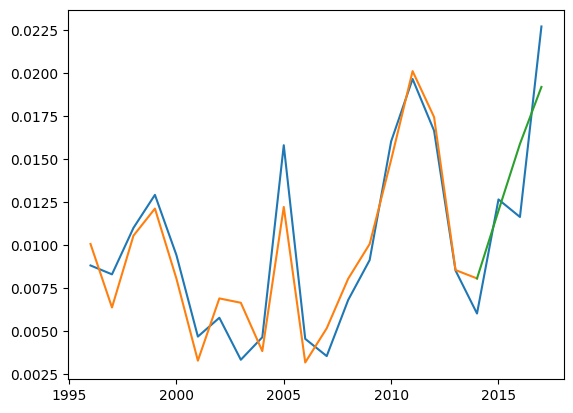

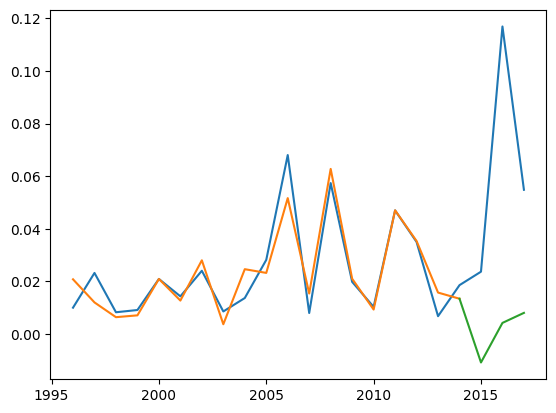

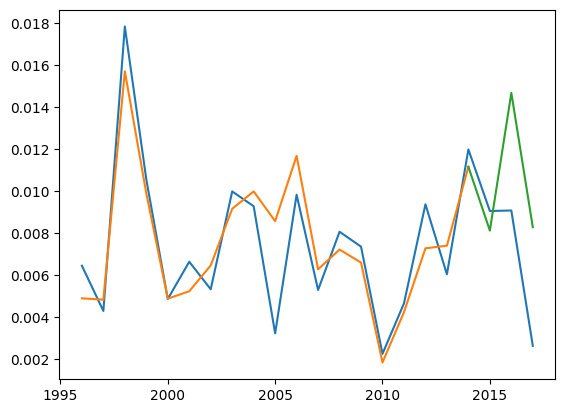

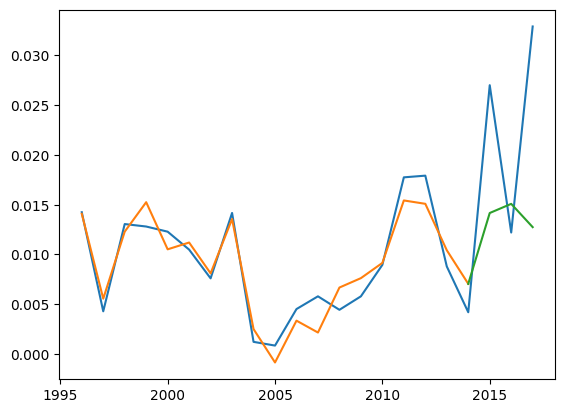

In [104]:
#Plot the best models against the true data
for fishName in salmonTypes_List:
    Years = list(range(1996, 2018))
    train_years = Years[:-test_size]
    test_years = Years[-test_size - 1:]
    X_train = catchless_salmon_features_MI[model_features[fishName]].iloc[:-test_size]
    X_test = catchless_salmon_features_MI[model_features[fishName]].iloc[-test_size - 1:]

    LR.fit(X_train,catchless_salmon_features_MI[fishName].iloc[:-test_size])
    y_train = LR.predict(X_train)
    y_test = LR.predict(X_test)
    
    plt.plot(Years, catchless_salmon_features_MI[fishName])
    plt.plot(train_years, y_train)
    plt.plot(test_years, y_test)

    plt.show()
    plt.close()